# Features

## Use `dataloader` to get an utterance

In [1]:
from dataloader import get_dataloader
import torch
import numpy as np

# CTC model for ASR

## Obtain phoneme output units

In [2]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

## Model & training configurations

In [3]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 2,
        'fbank_dims': 23,
        'model_dims': 128,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'dropout': 0.3,
        'num_epochs': 20,
        'device': device,
        'optimiser': 'sgd',
        'grad_clip': 0.5
       }

args = namedtuple('x', args)(**args)

In [5]:
import models
model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab), dropout=args.dropout, 
)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 562216


## Training

In [6]:
# from datetime import datetime
# from trainer import train
# start = datetime.now()
# model.to(args.device)
# model_path = train(model, args)
# end = datetime.now()
# duration = (end - start).total_seconds()
# print('Training finished in {} minutes.'.format(divmod(duration, 60)[0]))
# print('Model saved to {}'.format(model_path))

## Decoding

In [7]:
## You can uncomment the following line and change model path to the model you want to decode
model_path="checkpoints/20231207_193515/model_20"

In [8]:
import torch
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Loading model from checkpoints/20231207_193515/model_20


BiLSTM(
  (lstm): LSTM(23, 128, num_layers=2, dropout=0.3, bidirectional=True)
  (proj): Linear(in_features=256, out_features=40, bias=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)

In [9]:
import json
single_utt = {
    "MDAB0_SI1669.WAV": {"duration": 2.0608125, 
                         "phn": "sil b iy ih sil k s ay dx ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh l f sil", 
                         "spk_id": "MDAB0", "fbank": "/rds/user/ejg84/hpc-work/MLMI2/TIMIT/data/fbanks/test/MDAB0/SI1669.WAV"
                        }
}
with open('single_utt.json', 'w+') as f:
    json.dump(single_utt, f)

## 3.2.1

In [10]:
# decode script - vis

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

def decode(model, args, json_file, char=False):
    struct_for_heatmap = None
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            struct_for_heatmap = outputs
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
            print(outputs)
#         print(outputs)
#         print(outputs.shape)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]
        print(outputs)
        
    return struct_for_heatmap


In [11]:
results = decode(model, args, 'single_utt.json')
# print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))
results

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  9,  4,  0,  0,  0,  0,
          0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  9, 17, 17,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  0,
          0,  0, 29,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  9,  9, 27,  0,
          0,  1,  0,  0,  0,  0, 29,  0,  0,  0,  0,  9,  9, 34,  0,  0,  0,  0,
          0, 18,  0,  0,  0,  0,  0, 29,  0,  0,  1,  0,  0,  0,  0,  0, 27, 27,
          0,  0,  0,  0,  0,  1,  0,  0,  0,  0, 29, 25,  0,  0,  0,  0, 24,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,
          0,  7,  0,  0,  0,  0, 17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0, 24, 24,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  9]])
['sil dh iy sil s ay n er sil d ih n sil t ow n ih d ih n ah f ay er s l f

tensor([[[9.9974e-01, 2.8465e-06, 3.5756e-07,  ..., 1.2328e-07,
          3.3239e-08, 1.0082e-07]],

        [[9.9990e-01, 7.7355e-07, 3.3768e-07,  ..., 2.7987e-08,
          5.4543e-09, 1.8870e-08]],

        [[9.9992e-01, 5.1693e-07, 5.7811e-07,  ..., 1.5380e-08,
          2.6181e-09, 1.1235e-08]],

        ...,

        [[9.9976e-01, 1.6209e-08, 6.4355e-08,  ..., 5.7051e-10,
          3.2276e-09, 4.6669e-08]],

        [[5.8694e-01, 8.3178e-08, 1.3706e-06,  ..., 1.0508e-08,
          1.1905e-07, 1.0132e-06]],

        [[4.9224e-03, 4.0743e-08, 1.8109e-06,  ..., 1.0196e-08,
          1.8984e-07, 3.8913e-07]]])

In [12]:
# plot heatmap
data_to_plot = results[5:25]
data_to_plot.shape

torch.Size([20, 1, 40])

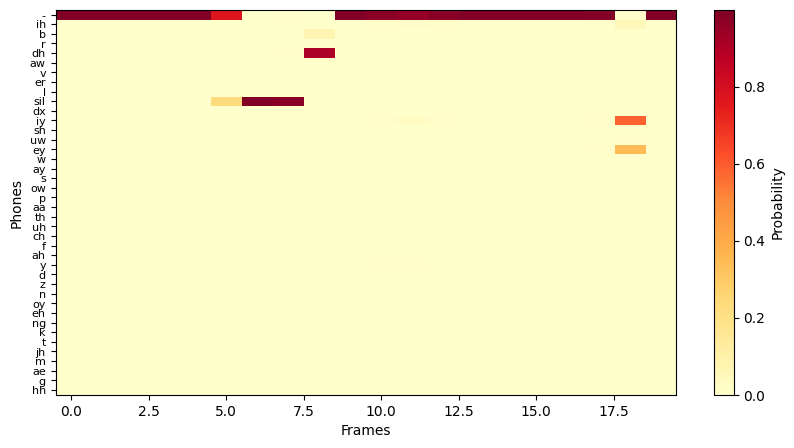

In [13]:
import torch
import matplotlib.pyplot as plt

# Squeeze the tensor to remove the singleton dimension (1)
tensor_squeezed = torch.transpose(data_to_plot.squeeze(),0,1)

# Convert the tensor to a NumPy array
tensor_numpy = tensor_squeezed.numpy()

# Plotting the heatmap
plt.figure(figsize=(10,5))
plt.imshow(tensor_numpy, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Probability')
plt.xlabel('Frames')
plt.ylabel('Phones')
y_labels = ['-'] + list(args.vocab.keys())[1:]
plt.yticks(np.arange(len(args.vocab)), y_labels, fontsize=8)
plt.show()


# 3.2.2

In [14]:
# decode script - blank penalty

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

bp = 0.8

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)

            # apply blank penalty
            outputs[:,0,0] -= (bp*outputs[:,0,0])
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
            
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]
        for out in outputs:
            if out != trans:
                print(out)
                print(trans[0]+'\n')

        if '61'in args.vocab:
            outputs = [" ".join(map_to_39(i)) for i in outputs]

        if char:
            cur_stats = cer(trans, outputs, return_dict=True)
        else:
            cur_stats = compute_measures(trans, outputs)
        stats[0] += cur_stats["substitutions"]
        stats[1] += cur_stats["deletions"]
        stats[2] += cur_stats["insertions"]
        stats[3] += cur_stats["hits"]

    total_words = stats[0] + stats[1] + stats[3]
    sub = stats[0] / total_words * 100
    dele = stats[1] / total_words * 100
    ins = stats[2] / total_words * 100
    cor = stats[3] / total_words * 100
    err = (stats[0] + stats[1] + stats[2]) / total_words * 100
    return sub, dele, ins, cor, err

In [15]:
results = decode(model, args, args.test_json)

sil hh iy hh ow z n eh v er hh ih m s eh l f sil t ih iy hh ey f l w ih sil ch sil t sil b iy hh ey dx er sil t sil w ih sil ch ih v ah s hh ae z sil
sil hh iy hh eh z n eh v er hh ih m s eh l f sil d ah n ey hh ih ng f ow w ih sil ch sil t ah sil b iy hh ey dx ih sil w ih sil ch ih v ah s hh ae z sil

sil dh iy sil s ay n er sil d ih n sil t ow n ih sil d ih n ah f ay er s l f sil
sil b iy ih sil k s ay dx ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh l f sil

sil ae sil t w ay l ey sil t ah m ih s f w aa f th sil dh ey l hh n ah v sh ih sil b l iy sil
sil ae sil t sil w aa l ay sil t ah m ah sil t sil w eh l th sil d ey w l hh ae v sh ah sil b l iy sil

sil s ah n sil t ay s iy sil k aa ah s ay dx ah w ah f sil ay f aa ih sil s sil b iy ih hh l m sil
sil s ah m sil t ay m s iy sil k ow ah n s ay dx ah w ah th m ay f aa dh ih z sil b iy ng eh sil t hh ow m sil

sil iy dx iy ng s sil p ih dx ih sil jh sil n ay l iy ey ng sil k r iy s ih s sil t r ey sil th sil m ay sil f l ah 

sil ih n sil t iy dx ih dx ih z sil p aa s ah sil b ah sil t ih s eh sil p er r ey sil iy n l eh sil t aa n sil p hh eh r er m eh ng eh n ih f ah m uw sil k l iy r ih th eh n sil s sil
sil ih n sil d iy sil ih dx ih z sil p aa s ah sil b l sil t ih s eh sil p er ey iy l eh sil t r aa n sil p eh er m ae ng n eh dx ih sil f r ah m n uw sil k l iy er ih f eh sil s sil

sil dh ah v iy sil p ay n sil ah v er l eh sil dh iy eh s ih n sil
sil dh ah v y uw sil p oy n sil ow v er l uh sil dh iy ow sh ih n sil

sil aa sil d v r aa sil d ih s ah sil b l ey sil p ih dx ah hh ae v ih n iy n ih v sil t ch ey m sil s sil
sil ay sil d r ay sil dh ih s ah sil b w ey sil b ih dx ay hh ae v ih n iy n ah f sil ch ey n sil jh sil

sil dh ih sil k l ah n sil z iy sil k eh s ah m er s sil t ih l sil th ah m iy s sil t ih n dh s ih v sil p er v f y er m sil
sil dh ih sil k l ah m z iy sil k ah s sil t ih m er s sil p ih l sil s ah m ih sil s sil p ih n s ih v sil p er f y uw m sil

sil f eh l v ay ey s ih n r

sil n ah ng sil ch l dx ih n sil ch ih dx er v aa r sil d ih sil k s sil p aa r z er sil t ih sil k ih n sil p ey sil jh ih s sil t ih z uw z n z sil
sil y ah ng sil ch ih l sil er n sh uh dx ah v oy sil d ih sil k s sil p ow sh er sil t ah sil k ih n sil t ey sil jh ah s sil d ih z iy z ih z sil

sil sh ih s l ih sil t ih n s sil b r ey n sil d er ae ng sil k aa r n dh ih s sil t iy sil f s l ow sil p er sil
sil sh iy s l ih sil t n s sil p r ey n d er ae ng sil k l aa n ah s sil t iy sil s l ow sil p sil

sil w ih dh ih sil p r er f sil ah l aa sh ih z er v er y uw s f ah n s iy eh dx l sil
sil w eh dh er sil p r uw f sil g l aa sh ih z er v er iy y uw s f l n s iy ae dx l sil

sil w ah l aa n ih n s eh hh w er sil k ih n aa f ih n sil b iy f l ih m z iy sil
sil ah l uw m ah n ih m s ih l v ah w er sil k ih n aa f n sil b iy f l ih m z iy sil

sil hh y iy r ah sil b ih z ay s l iy sil p ah l iy w ih th sil w ah n y uw sil jh sil p aa l sil
sil hh iy r ah sil d ih z ay s l iy sil p l 

sil dh ih n ih s sil k l ow w ih z r iy sil t r ae sil t ih sil d w ih sil th ih n ah sil p aa l ih sil jh iy ng sil
sil dh ih m ih s sil k w ow w ih z r iy sil t r ae sil t ih sil d w ih sil th ih n ah sil p aa l ih sil jh iy sil

sil sh ey n ih ng sil t r ey m ih z ih sil p l aa sil p iy l er ay dx ih m ah n hh aa l ih w iy n sil
sil sh ey v iy n sil k r iy m ih z ih sil p aa sil p y uw l er ay dx eh m aa n hh aa l ah w iy n sil

sil hh eh l sil t sil g r eh sil t ih sil p ih sil k ah sil b ae sil k ih th sil b ih sil t ey dx ah n z sil
sil hh eh l sil p sil g r ey sil t ih sil p ih sil k ih sil p eh sil k ih v sil p ih sil t ey dx ow z sil

sil dh ey ae dx ih sil b ih ng hh aw s ih n dh ah er m ow sil k eh n sil t iy s ay sil d sil
sil dh ey ow n ah sil b ih sil hh aw s ih n dh ah r er m ow sil k ah n sil t r iy s ay sil d sil

sil m ay sil k ow sil k ah l ih sil dh ih sil b eh sil d er m w aa w ih th sil k r ay n z sil
sil m ay sil k l sil k ah l er sil dh ih sil b eh sil d r uw m 

sil jh ey m ey l ih n m aa r m dx n iy sil b ay w er sil k ih ng k aa r sil d sil
sil jh ey n m ey er n m aa r m ah n iy sil b ay w er sil k ih ng hh aa r sil d sil

sil b iy sil ch eh n sil t ay m l iy ih n sil k ah m w aa s sil k ah n sil s ay dx ah w ih th ah sil p r iy sil d eh aw n ah v f ih sil k iy dx ih ng s ih s sil t n sil p aa r sil k sil
sil iy sil ch ah n sil t ay m l iy ih n sil k ah m l aa s sil k ow ah n s ay dx ih w ih th ah sil b r ey sil d aw n ah v ih hh iy dx iy ng s ih s sil t m sil p aa r sil

sil d ah n s sil t uw z l ah v th sil k aa n ih ng sil k ae n y uw z sil t r iy sil t s sil
sil y ah ng s sil t uw z sil l ah v sil k aa m ih n sil k ae n sil d iy z sil t r iy sil s sil

sil ih n w ah n ay s sil t ey w er sil
sil eh n w ah dx ay z dh ey w er sil

sil dh ah v f w iy s uw uw th sil b ay v dh ah l ih sil k ch er r ih z sil m ih s aa ay sh sil
sil k l ih f w ih s uw dh sil b ay dh ah l ih sil sh er r iy ih s sil m ih s aa sh sil

sil dh ih sil k ae sil t s sil

In [16]:
# 0.1
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

SUB: 16.24%, DEL: 4.77%, INS: 5.83%, COR: 78.99%, PER: 26.83%


In [17]:
# 0.5
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

SUB: 16.24%, DEL: 4.77%, INS: 5.83%, COR: 78.99%, PER: 26.83%


In [18]:
# 0.8
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

SUB: 16.24%, DEL: 4.77%, INS: 5.83%, COR: 78.99%, PER: 26.83%


In [19]:
# find a good example

## 3.2.3

In [74]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_61.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]
vocab

{'_': 0,
 'sil': 1,
 'aa': 2,
 'ae': 3,
 'ah': 4,
 'ao': 5,
 'aw': 6,
 'ax': 7,
 'ax-h': 8,
 'axr': 9,
 'ay': 10,
 'b': 11,
 'bcl': 12,
 'ch': 13,
 'd': 14,
 'dcl': 15,
 'dh': 16,
 'dx': 17,
 'eh': 18,
 'el': 19,
 'em': 20,
 'en': 21,
 'eng': 22,
 'epi': 23,
 'er': 24,
 'ey': 25,
 'f': 26,
 'g': 27,
 'gcl': 28,
 'h#': 29,
 'hh': 30,
 'hv': 31,
 'ih': 32,
 'ix': 33,
 'iy': 34,
 'jh': 35,
 'k': 36,
 'kcl': 37,
 'l': 38,
 'm': 39,
 'ng': 40,
 'n': 41,
 'nx': 42,
 'ow': 43,
 'oy': 44,
 'p': 45,
 'pau': 46,
 'pcl': 47,
 'q': 48,
 'r': 49,
 's': 50,
 'sh': 51,
 't': 52,
 'tcl': 53,
 'th': 54,
 'uh': 55,
 'uw': 56,
 'ux': 57,
 'v': 58,
 'w': 59,
 'y': 60,
 'z': 61,
 'zh': 62}

In [ ]:
copy_args = {'seed': 123,
        'train_json': 'train_fbank61.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 2,
        'fbank_dims': 23,
        'model_dims': 128,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'dropout': 0.3,
        'num_epochs': 20,
        'device': device,
        'optimiser': 'sgd',
        'grad_clip': 0.5
       }

copy_args = namedtuple('y', copy_args)(**copy_args)

In [75]:
import models
model = models.BiLSTM(
    copy_args.num_layers, copy_args.fbank_dims * copy_args.concat, 
    copy_args.model_dims, len(copy_args.vocab), dropout=copy_args.dropout
)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 562216


In [ ]:
import torch
model_path="checkpoints/20231207_193515/model_20"
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

In [72]:
# decode script - full phn set

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

# build global phone map
phone_map = {}

with open('phone_map') as f:
    lines = f.readlines()
    for line in lines:
        line_split = line.split(':')
        orig_phn = line_split[0]
        mapped_39_phn = line_split[1]
        phone_map[orig_phn] = mapped_39_phn.strip('\n')

def map_to_39(phns):
    mapped_phns = []
    for phn in phns[0].split():
        mapped_phn = phone_map[phn]
        mapped_phns.append(mapped_phn.strip())
    return [" ".join(mapped_phns)]

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]

        if args.train_json == 'train_fbank61.json':
            print(f'old outputs are: {outputs}')
            outputs = map_to_39(outputs)
            print(f'need to map phones: {outputs}')

        if char:
            cur_stats = cer(trans, outputs, return_dict=True)
        else:
            cur_stats = compute_measures(trans, outputs)
        stats[0] += cur_stats["substitutions"]
        stats[1] += cur_stats["deletions"]
        stats[2] += cur_stats["insertions"]
        stats[3] += cur_stats["hits"]

    total_words = stats[0] + stats[1] + stats[3]
    sub = stats[0] / total_words * 100
    dele = stats[1] / total_words * 100
    ins = stats[2] / total_words * 100
    cor = stats[3] / total_words * 100
    err = (stats[0] + stats[1] + stats[2]) / total_words * 100
    return sub, dele, ins, cor, err

# test = 'sil dh iy ih sil s k oy tcl ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh el f sil'.split()
# print(phone_map)
# print(map_to_39(test))

In [73]:
results = decode(model, copy_args, args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

old outputs are: ['sil hh iy hh ow z n eh v er hh ih m s eh l sil t ih iy hh ey f l w ih sil ch sil t sil iy hh ey er sil w ih sil ch ih v ah s hh ae z sil']
need to map phones: ['sil hh iy hh ow z n eh v er hh ih m s eh l sil t ih iy hh ey f l w ih sil ch sil t sil iy hh ey er sil w ih sil ch ih v ah s hh ae z sil']
old outputs are: ['sil dh iy sil s ay n er sil d ih n sil t ow n ih d ih n ah f ay er s l f sil']
need to map phones: ['sil dh iy sil s ay n er sil d ih n sil t ow n ih d ih n ah f ay er s l f sil']
old outputs are: ['sil ae sil t w ay l ey sil t ah m ih s aa th sil dh ey n ah sh ih sil b l iy sil']
need to map phones: ['sil ae sil t w ay l ey sil t ah m ih s aa th sil dh ey n ah sh ih sil b l iy sil']
old outputs are: ['sil s ah n sil t ay s iy sil k aa ah s ay dx ah w ah f ay f ih s sil b iy ih hh l m sil']
need to map phones: ['sil s ah n sil t ay s iy sil k aa ah s ay dx ah w ah f ay f ih s sil b iy ih hh l m sil']
old outputs are: ['sil iy dx iy ng s sil p ih dx ih si

old outputs are: ['sil m ow n ih sil k s sil t ih sil z ih s sil f aa l ah sil v s ih m sil p l er l ay n z sil']
need to map phones: ['sil m ow n ih sil k s sil t ih sil z ih s sil f aa l ah sil v s ih m sil p l er l ay n z sil']
old outputs are: ['sil eh l sil d er v ih sil t iy f ih ng er aa f ih n ih sil k s sil k l uw sil dx ih sil d sil']
need to map phones: ['sil eh l sil d er v ih sil t iy f ih ng er aa f ih n ih sil k s sil k l uw sil dx ih sil d sil']
old outputs are: ['sil sh uw w ih z r eh dx ih f aa hh er sil g r ey dx ih v eh n sil ch er z ih n dh ih r aa f l l ah v er m ow l sil p aa r sil sil']
need to map phones: ['sil sh uw w ih z r eh dx ih f aa hh er sil g r ey dx ih v eh n sil ch er z ih n dh ih r aa f l l ah v er m ow l sil p aa r sil sil']
old outputs are: ['sil g r aa f ay f ih m z n dh ah sil b aa sil sh sil w ah f aa r iy sil g uw l aw sil']
need to map phones: ['sil g r aa f ay f ih m z n dh ah sil b aa sil sh sil w ah f aa r iy sil g uw l aw sil']
old output

old outputs are: ['sil l r z sil k aa s sil t uw n iy dx ih sil b ay sil g l eh s ih sil b iy sil k ah m sil p l iy l iy eh l ih sil g ih n sil']
need to map phones: ['sil l r z sil k aa s sil t uw n iy dx ih sil b ay sil g l eh s ih sil b iy sil k ah m sil p l iy l iy eh l ih sil g ih n sil']
old outputs are: ['sil t ih f er dh er hh ih z sil p r ih s sil t iy iy sil ch hh ih sil k ey sh n ih r iy z dh ah w aa s sil t r iy sil jh er n l sil']
need to map phones: ['sil t ih f er dh er hh ih z sil p r ih s sil t iy iy sil ch hh ih sil k ey sh n ih r iy z dh ah w aa s sil t r iy sil jh er n l sil']
old outputs are: ['sil d eh s dh ih sil k w eh sh ih n f ah n iy ae n sil s er sil']
need to map phones: ['sil d eh s dh ih sil k w eh sh ih n f ah n iy ae n sil s er sil']
old outputs are: ['sil w eh er er uw w eh iy w er w ey sil']
need to map phones: ['sil w eh er er uw w eh iy w er w ey sil']
old outputs are: ['sil dh ey hh ih sil s l ae sil dh ih er f ay s sil']
need to map phones: ['sil 

old outputs are: ['sil hh aw l ey ih n f r iy w ey m iy n ih s ay m sil t ey m sil']
need to map phones: ['sil hh aw l ey ih n f r iy w ey m iy n ih s ay m sil t ey m sil']
old outputs are: ['sil dh ih s sil p ah sh er ih ih s sil p eh sil dh ih n f aa m sil t ih f aa r sil p er s sil p eh k sil t ah v sil b er']
need to map phones: ['sil dh ih s sil p ah sh er ih ih s sil p eh sil dh ih n f aa m sil t ih f aa r sil p er s sil p eh k sil t ah v sil b er']
old outputs are: ['sil sh y uw w aa r w er f iy s iy w ah v ah n ow f er s sil']
need to map phones: ['sil sh y uw w aa r w er f iy s iy w ah v ah n ow f er s sil']
old outputs are: ['sil r ae f sil t ih n sil t r ow sil dh ih s sil t aw sil p aa sil ch f er n dh ah sil p iy sil ch er s sil']
need to map phones: ['sil r ae f sil t ih n sil t r ow sil dh ih s sil t aw sil p aa sil ch f er n dh ah sil p iy sil ch er s sil']
old outputs are: ['sil d uw w ih th aw f eh sil s iy sil t ey sil b l f aa l ih s sil']
need to map phones: ['sil 

old outputs are: ['er er sil g r ey sil jh hh ay er aa er sil l aa er dh ah n ae n sil s iy z sil']
need to map phones: ['er er sil g r ey sil jh hh ay er aa er sil l aa er dh ah n ae n sil s iy z sil']
old outputs are: ['sil dh iy ey s ih s sil w ah z ih m er aa ay sh sil']
need to map phones: ['sil dh iy ey s ih s sil w ah z ih m er aa ay sh sil']
old outputs are: ['sil dh eh n ah oy z sil k r aa ah n sil g r eh l z sil m r ah n ow ey iy sil ch sil t ey ey sil']
need to map phones: ['sil dh eh n ah oy z sil k r aa ah n sil g r eh l z sil m r ah n ow ey iy sil ch sil t ey ey sil']
old outputs are: ['sil m iy sil k s sil dh er r iy ey sh ih n sil p r aa s eh s iy n sil hh ah v iy sil t ah z r iy s iy sil d ih sil k s sil t eh n s uw ih n m eh s sil t ih sil g ey sh n sil']
need to map phones: ['sil m iy sil k s sil dh er r iy ey sh ih n sil p r aa s eh s iy n sil hh ah v iy sil t ah z r iy s iy sil d ih sil k s sil t eh n s uw ih n m eh s sil t ih sil g ey sh n sil']
old outputs are: [

old outputs are: ['sil k aa r r iy ih n sil t r ih sh sil p l ey sil t ae sil w ih sil b iy sil ch sil b aa l th er er z sil']
need to map phones: ['sil k aa r r iy ih n sil t r ih sh sil p l ey sil t ae sil w ih sil b iy sil ch sil b aa l th er er z sil']
old outputs are: ['sil dx ah f v iy sil p l l r ow n ih s sil t r iy sil t s ih n sil k aa s sil t ah m z ih n m ae s sil k s sil ih n eh v ih ng ah m sil b aa l sil']
need to map phones: ['sil dx ah f v iy sil p l l r ow n ih s sil t r iy sil t s ih n sil k aa s sil t ah m z ih n m ae s sil k s sil ih n eh v ih ng ah m sil b aa l sil']
old outputs are: ['sil ah f iy er z l ey dx er dh ih sil d ow n f eh l ih n sil']
need to map phones: ['sil ah f iy er z l ey dx er dh ih sil d ow n f eh l ih n sil']
old outputs are: ['sil ih ng sil k r iy s ih ng sil t eh m sil p ow ah f n uw sil p r aa dx ih sil d ih v eh l sil m ih sil']
need to map phones: ['sil ih ng sil k r iy s ih ng sil t eh m sil p ow ah f n uw sil p r aa dx ih sil d ih v eh

## 3.2.4

In [16]:
# decode script - confusion

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    predictions = []
    ground_truth = []
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        ground_truth.append(trans[0].split())
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
#         outputs = [" ".join(i) for i in outputs]
        predictions.append(outputs[0])
        
    return predictions, ground_truth

In [17]:
predictions, ground_truth = decode(model, args, args.test_json)

In [18]:
print(predictions[0])
print(ground_truth[0])

['sil', 'hh', 'iy', 'hh', 'ow', 'z', 'n', 'eh', 'v', 'er', 'hh', 'ih', 'm', 's', 'eh', 'l', 'sil', 't', 'ih', 'iy', 'hh', 'ey', 'f', 'l', 'w', 'ih', 'sil', 'ch', 'sil', 't', 'sil', 'iy', 'hh', 'ey', 'er', 'sil', 'w', 'ih', 'sil', 'ch', 'ih', 'v', 'ah', 's', 'hh', 'ae', 'z', 'sil']
['sil', 'hh', 'iy', 'hh', 'eh', 'z', 'n', 'eh', 'v', 'er', 'hh', 'ih', 'm', 's', 'eh', 'l', 'f', 'sil', 'd', 'ah', 'n', 'ey', 'hh', 'ih', 'ng', 'f', 'ow', 'w', 'ih', 'sil', 'ch', 'sil', 't', 'ah', 'sil', 'b', 'iy', 'hh', 'ey', 'dx', 'ih', 'sil', 'w', 'ih', 'sil', 'ch', 'ih', 'v', 'ah', 's', 'hh', 'ae', 'z', 'sil']


In [19]:
import Levenshtein
import numpy as np

V = 41
vocab = []

with open('vocab_39.txt') as f:
    lines = f.readlines()
    for phn in lines:
        vocab.append(phn.strip('\n'))

def compute_confusion(predictions, ground_truth):
    C = np.zeros(V*V).reshape(V,V)
    for pred, gt in zip(predictions, ground_truth):
        ops = Levenshtein.editops(pred, gt)
        indices_affected = []
        for op, pos_p, pos_gt in ops: 
            indices_affected.append(pos_p)

        for op, pos_p, pos_gt in ops: 
            if pos_p == len(pred):
                continue
            gt_phn_idx = vocab.index(gt[pos_gt])
            p_phn_idx = vocab.index(pred[pos_p])

            if op == 'insert':
                C[:,-1][p_phn_idx] += 1
            elif op == 'delete':
                C[-1][p_phn_idx] += 1
            elif op == 'replace':
                C[gt_phn_idx][p_phn_idx] += 1
                C[p_phn_idx][gt_phn_idx] += 1
            else:
                print(f'op {op} is not considered in our case')
        
        for i in range(len(pred)):
            if i not in indices_affected:
                curr_count = C[vocab.index(pred[i])][vocab.index(pred[i])]
                if curr_count < 100:
                    C[vocab.index(pred[i])][vocab.index(pred[i])] += 1
              
    return C

In [20]:
# compute confusion matrix
C = compute_confusion(predictions,ground_truth)
C   

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   2., ...,   0.,   1.,  73.],
       [  0.,   2., 100., ...,   1.,   0.,   3.],
       ...,
       [  0.,   0.,   1., ...,  48.,   0.,   2.],
       [  0.,   1.,   0., ...,   0.,  44.,   4.],
       [  0.,  21.,   3., ...,   2.,   2.,   0.]])

([<matplotlib.axis.XTick at 0x7f0de249a430>,
 [Text(0, 0, '-'),
  Text(1, 0, 'ih'),
  Text(2, 0, 'b'),
  Text(3, 0, 'r'),
  Text(4, 0, 'dh'),
  Text(5, 0, 'aw'),
  Text(6, 0, 'v'),
  Text(7, 0, 'er'),
  Text(8, 0, 'l'),
  Text(9, 0, 'sil'),
  Text(10, 0, 'dx'),
  Text(11, 0, 'iy'),
  Text(12, 0, 'sh'),
  Text(13, 0, 'uw'),
  Text(14, 0, 'ey'),
  Text(15, 0, 'w'),
  Text(16, 0, 'ay'),
  Text(17, 0, 's'),
  Text(18, 0, 'ow'),
  Text(19, 0, 'p'),
  Text(20, 0, 'aa'),
  Text(21, 0, 'th'),
  Text(22, 0, 'uh'),
  Text(23, 0, 'ch'),
  Text(24, 0, 'f'),
  Text(25, 0, 'ah'),
  Text(26, 0, 'y'),
  Text(27, 0, 'd'),
  Text(28, 0, 'z'),
  Text(29, 0, 'n'),
  Text(30, 0, 'oy'),
  Text(31, 0, 'eh'),
  Text(32, 0, 'ng'),
  Text(33, 0, 'k'),
  Text(34, 0, 't'),
  Text(35, 0, 'jh'),
  Text(36, 0, 'm'),
  Text(37, 0, 'ae'),
  Text(38, 0, 'g'),
  Text(39, 0, 'hh')])

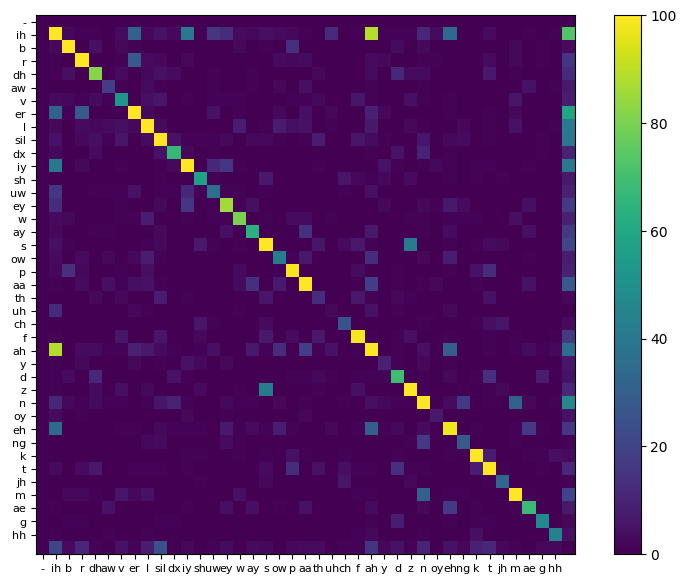

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.imshow(C)
plt.colorbar()
tick_labels = ['-'] + list(args.vocab.keys())[1:]
plt.yticks(np.arange(len(args.vocab)), tick_labels, fontsize=8)
plt.xticks(np.arange(len(args.vocab)), tick_labels, fontsize=8)

In [22]:
print(vocab[28], vocab[17])

z s


## Plotting

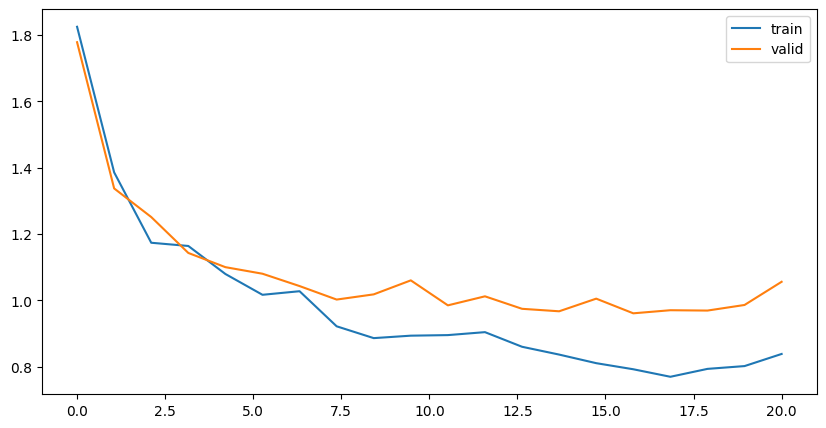

In [23]:
import matplotlib.pyplot as plt

# init
plt.figure(figsize=(10,5))

train_loss = [
    1.82474,
1.38592,
1.17388,
1.16418,
1.07972,
1.01704,
1.02782,
0.92208,
0.88646,
0.89385,
0.89556,
0.90447,
0.86040,
0.83687,
0.81099,
0.79263,
0.76997,
0.79377,
0.80220,
0.83875,
]
    
valid_loss =    [
        1.77826,
1.33755,
1.25135,
1.14313,
1.10031,
1.08053,
1.04334,
1.00266,
1.01832,
1.06050,
0.98522,
1.01243,
0.97481,
0.96733,
1.00541,
0.96122,
0.97055,
0.96949,
0.98636,
1.05625,
    ]

xs = np.linspace(0,20,20)
plt.plot(xs,train_loss, label='train')
plt.plot(xs,valid_loss, label='valid')

plt.legend()
plt.show()

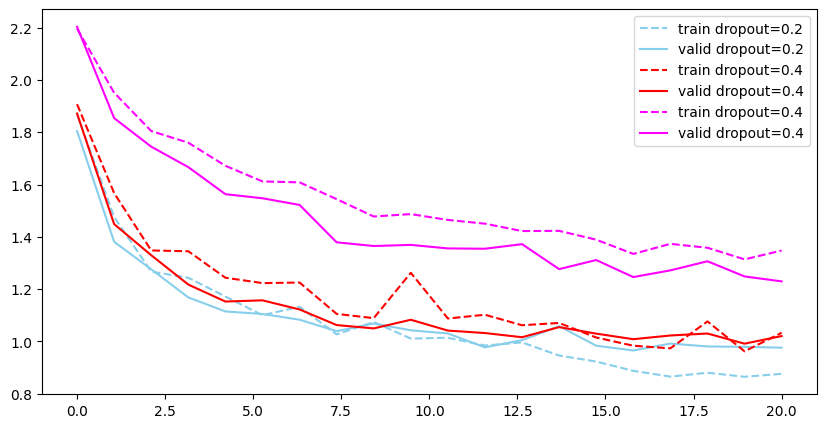

In [24]:
# q3.1.1 - reg - dropout
train_loss_20 = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

valid_loss_20 = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

valid_loss_40 = [
    1.87132,
1.44844,
1.32950,
1.21715,
1.15236,
1.15691,
1.12203,
1.06235,
1.04955,
1.08263,
1.04120,
1.03185,
1.01577,
1.05450,
1.02959,
1.00825,
1.02248,
1.03002,
0.99114,
1.02020,
]

train_loss_40 = [
    1.90710,
1.56695,
1.34766,
1.34472,
1.24340,
1.22281,
1.22502,
1.10505,
1.08880,
1.26224,
1.08744,
1.10180,
1.06166,
1.07035,
1.01475,
0.98333,
0.97323,
1.07628,
0.96197,
1.03284,
]

train_loss_30 = [
    
]
valid_loss_30 = [
    
]
train_loss_80 = [
    2.19590,
1.95108,
1.80447,
1.75987,
1.67162,
1.61176,
1.60819,
1.54393,
1.47756,
1.48682,
1.46443,
1.45013,
1.42194,
1.42271,
1.38896,
1.33448,
1.37300,
1.35801,
1.31358,
1.34733,
]

valid_loss_80 = [
    2.20331,
1.85385,
1.74465,
1.66643,
1.56301,
1.54731,
1.52184,
1.37887,
1.36469,
1.36899,
1.35550,
1.35432,
1.37186,
1.27634,
1.31106,
1.24594,
1.27151,
1.30640,
1.24841,
1.22941,
]


plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,train_loss_20, label='train dropout=0.2', c='skyblue', linestyle='--')
plt.plot(xs,valid_loss_20, label='valid dropout=0.2', c='skyblue')
plt.plot(xs,train_loss_40, label='train dropout=0.4', c='r', linestyle='--')
plt.plot(xs,valid_loss_40, label='valid dropout=0.4', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

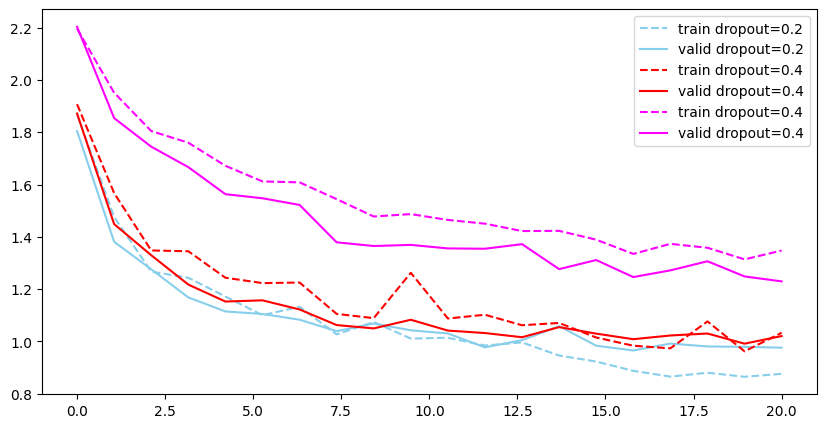

In [25]:
# q3.1.1 - reg - clip
train_loss_20 = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

valid_loss_20 = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

valid_loss_40 = [
    1.87132,
1.44844,
1.32950,
1.21715,
1.15236,
1.15691,
1.12203,
1.06235,
1.04955,
1.08263,
1.04120,
1.03185,
1.01577,
1.05450,
1.02959,
1.00825,
1.02248,
1.03002,
0.99114,
1.02020,
]

train_loss_40 = [
    1.90710,
1.56695,
1.34766,
1.34472,
1.24340,
1.22281,
1.22502,
1.10505,
1.08880,
1.26224,
1.08744,
1.10180,
1.06166,
1.07035,
1.01475,
0.98333,
0.97323,
1.07628,
0.96197,
1.03284,
]

train_loss_30 = [
    
]
valid_loss_30 = [
    
]
train_loss_80 = [
    2.19590,
1.95108,
1.80447,
1.75987,
1.67162,
1.61176,
1.60819,
1.54393,
1.47756,
1.48682,
1.46443,
1.45013,
1.42194,
1.42271,
1.38896,
1.33448,
1.37300,
1.35801,
1.31358,
1.34733,
]

valid_loss_80 = [
    2.20331,
1.85385,
1.74465,
1.66643,
1.56301,
1.54731,
1.52184,
1.37887,
1.36469,
1.36899,
1.35550,
1.35432,
1.37186,
1.27634,
1.31106,
1.24594,
1.27151,
1.30640,
1.24841,
1.22941,
]


plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,train_loss_20, label='train dropout=0.2', c='skyblue', linestyle='--')
plt.plot(xs,valid_loss_20, label='valid dropout=0.2', c='skyblue')
plt.plot(xs,train_loss_40, label='train dropout=0.4', c='r', linestyle='--')
plt.plot(xs,valid_loss_40, label='valid dropout=0.4', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

In [26]:
# q3.1.2 - optimiser
sgd = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

adam = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,sgd_train, label='train optimiser=sgd', c='skyblue', linestyle='--')
plt.plot(xs,sgd_valid, label='valid optimiser=sgd', c='skyblue')
plt.plot(xs,adam_train, label='train optimiser=adam', c='r', linestyle='--')
plt.plot(xs,adam_valid, label='valid optimiser=adam', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

NameError: name 'sgd_train' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# q3.1.2 - complexity
train_loss_20 = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

valid_loss_20 = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

valid_loss_40 = [
    1.87132,
1.44844,
1.32950,
1.21715,
1.15236,
1.15691,
1.12203,
1.06235,
1.04955,
1.08263,
1.04120,
1.03185,
1.01577,
1.05450,
1.02959,
1.00825,
1.02248,
1.03002,
0.99114,
1.02020,
]

train_loss_40 = [
    1.90710,
1.56695,
1.34766,
1.34472,
1.24340,
1.22281,
1.22502,
1.10505,
1.08880,
1.26224,
1.08744,
1.10180,
1.06166,
1.07035,
1.01475,
0.98333,
0.97323,
1.07628,
0.96197,
1.03284,
]

train_loss_30 = [
    
]
valid_loss_30 = [
    
]
train_loss_80 = [
    2.19590,
1.95108,
1.80447,
1.75987,
1.67162,
1.61176,
1.60819,
1.54393,
1.47756,
1.48682,
1.46443,
1.45013,
1.42194,
1.42271,
1.38896,
1.33448,
1.37300,
1.35801,
1.31358,
1.34733,
]

valid_loss_80 = [
    2.20331,
1.85385,
1.74465,
1.66643,
1.56301,
1.54731,
1.52184,
1.37887,
1.36469,
1.36899,
1.35550,
1.35432,
1.37186,
1.27634,
1.31106,
1.24594,
1.27151,
1.30640,
1.24841,
1.22941,
]


plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,train_loss_20, label='train dropout=0.2', c='skyblue', linestyle='--')
plt.plot(xs,valid_loss_20, label='valid dropout=0.2', c='skyblue')
plt.plot(xs,train_loss_40, label='train dropout=0.4', c='r', linestyle='--')
plt.plot(xs,valid_loss_40, label='valid dropout=0.4', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

In [ ]:
import Levenshtein

def ctc_backtrace_with_editops(predicted_labels, ground_truth_labels, blank_symbol='-'):
    """
    Perform back tracing for CTC alignment using Levenshtein edit operations.

    Args:
    - predicted_labels (list): List of predicted labels.
    - ground_truth_labels (list): List of ground truth labels.
    - blank_symbol (str): CTC blank symbol.

    Returns:
    - aligned_labels (list): Aligned labels after back tracing.
    """

    # Combine predicted and ground truth labels into strings
    predicted_str = ''.join(predicted_labels)
    ground_truth_str = ''.join(ground_truth_labels)

    # Compute Levenshtein edit operations
    edit_ops = Levenshtein.editops(predicted_str, ground_truth_str)
    print(edit_ops)

    # Perform back tracing to align the sequences
    aligned_labels = []
    for op, pos1, pos2 in edit_ops:
        if op == 'replace' or op == 'insert':
            aligned_labels.append(predicted_labels[pos1])
        if op == 'replace' or op == 'delete':
            aligned_labels.append(blank_symbol)

    return aligned_labels

# Example usage:
predicted_sequence = ['A', 'A', '-', 'B', 'C', 'C', 'D', '-']
ground_truth_sequence = ['A', 'B', 'C', 'D']
aligned_sequence = ctc_backtrace_with_editops(predicted_sequence, ground_truth_sequence)
print("Predicted Sequence:", predicted_sequence)
print("Ground Truth Sequence:", ground_truth_sequence)
print("Aligned Sequence:", aligned_sequence)
